# Classification of Dogs and Cats
by Stefanie Müller

## 1. CNN
## 2. EfficientNet (B0)

#### Data source: <br>https://www.kaggle.com/tongpython/cat-and-dog
#### EfficientNet: <br>https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet

# Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import math

from matplotlib import pyplot as plt
import seaborn as sn

from keras.applications.efficientnet import preprocess_input

from sklearn.metrics import confusion_matrix

# Methods

## 1. Load data from directories

In [2]:
def load_data_cnn(target_image_size = 224):
    image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                                                rotation_range=20,
                                                                zoom_range=0.05,
                                                                width_shift_range=0.05,
                                                                height_shift_range=0.05,
                                                                shear_range=0.05,
                                                                horizontal_flip=True,
                                                                validation_split=0.2)

    test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                                               validation_split=0)    

    train_generator, val_generator, test_generator, single_test_images = __create_generators(image_gen, 
                                                                                             test_gen, 
                                                                                             target_image_size = target_image_size)
    
    return train_generator, val_generator, test_generator, single_test_images
    
def load_data_effnet(target_image_size = 224):
    image_gen = tf.keras.preprocessing.image.ImageDataGenerator(dtype='float32',
                                                                rescale=1. / 255,
                                                                validation_split=0.2,
                                                                preprocessing_function=preprocess_input)

    test_gen = tf.keras.preprocessing.image.ImageDataGenerator(dtype='float32',
                                                               rescale=1. / 255)    

    train_generator, val_generator, test_generator, single_test_images = __create_generators(image_gen, 
                                                                                             test_gen, 
                                                                                             target_image_size = target_image_size)
    
    return train_generator, val_generator, test_generator, single_test_images
    

def __create_generators(image_gen, test_gen, target_image_size):
    train_generator = image_gen.flow_from_directory(
        "CatDog_training_set/",
        target_size=(target_image_size, target_image_size),
        color_mode='rgb',
        batch_size=32,
        shuffle=True,
        seed=None,
        save_to_dir=None,
        follow_links=False,
        subset='training',
        class_mode='categorical'
    )

    val_generator = image_gen.flow_from_directory(
        "CatDog_training_set/",
        target_size=(target_image_size, target_image_size),
        color_mode='rgb',
        batch_size=32,
        shuffle=True,
        seed=None,
        save_to_dir=None,
        follow_links=False,
        subset='validation',
        class_mode='categorical'
    )
    
    test_generator = test_gen.flow_from_directory(
        "CatDog_test_set/",
        target_size=(target_image_size, target_image_size),
        color_mode='rgb',
        batch_size=1,
        shuffle=False,
        seed=None,
        save_to_dir=None,
        follow_links=False,
        # subset='training',
        class_mode='categorical'
    )
    #these images are cutted out from "CatDog_test_set"
    single_test_images = test_gen.flow_from_directory(
        "CatDog_single_test_images/",
        target_size=(target_image_size, target_image_size),
        color_mode='rgb',
        batch_size=12,
        shuffle=False,
        seed=None,
        save_to_dir=None,
        follow_links=False,
        # subset='training',
        class_mode='categorical'
    )
    
    return train_generator, val_generator, test_generator, single_test_images


##  2. Plot images

In [3]:
def plot_images(train_generator):
    batch = train_generator.next()
    plt.figure(figsize=(6, 6), dpi=100)
    
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        
        img = batch[0][i]
        plt.imshow(img)
        
        if np.argmax(batch[1][i]) == 0:
            plt.title('Cat', color='#36007a')            
        else:
            plt.title('Dog', color='#008594')
            
        plt.axis('off')    
    
    plt.tight_layout()
    plt.show()
    plt.close()

## 3. Create Model, compile and fit

In [4]:
def cnn_model(train_generator, val_generator, target_image_size=224):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=(target_image_size,target_image_size,3), 
                                     activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))    
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
    history = __model_compilefit(model, train_generator, val_generator, 
                              tf.keras.optimizers.RMSprop(learning_rate=0.002), patience=5, lr_reduc=True)
    
    return model, history


def effnet_model(train_generator, val_generator, target_image_size=224):
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=(target_image_size,target_image_size,3), 
        weights='imagenet', 
        include_top=False) 
    model = tf.keras.models.Sequential()
    
    model.add(base_model)    
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
    #higher learning rate causes the net to become instable
    history = __model_compilefit(model, train_generator, val_generator, 
                              tf.keras.optimizers.Adam(learning_rate=0.00001), patience=5, lr_reduc=False)
    
    return model, history

def __model_compilefit(model, train_generator, val_generator, opt, patience, lr_reduc):
    opt = opt        
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics='accuracy')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                      patience=patience,
                                                      restore_best_weights=True)
    callbacks = [early_stopping]
    
    if lr_reduc:
        learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
        callbacks = [early_stopping, learning_rate_reduction]
    
    history = model.fit(train_generator,
                        epochs=100,
                        validation_data=val_generator,                    
                        steps_per_epoch=train_generator.n / train_generator.batch_size,
                        validation_steps=val_generator.n / val_generator.batch_size,
                        callbacks=callbacks)
    return history

## 4. Plot Accuracies and Losses

In [5]:
def plots(history):
    plot_accuracies(history)
    plot_losses(history)
    
def plot_accuracies(history):
    plt.plot(history.history['accuracy'], label='training')
    plt.plot(history.history['val_accuracy'], label='validation')
    
    plt.title('Accuracies')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

def plot_losses(history):
    plt.plot(history.history['loss'], label='training', color='purple')
    plt.plot(history.history['val_loss'], label='validation', color='green')
    
    plt.title('Losses')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

## 5. Evaluate model on test data

In [6]:
def evaluate_model(model, test_generator):
    print("\nModel Evaluation on Test-Data:")
    model.evaluate(test_generator, steps=test_generator.n / test_generator.batch_size)

## 6. Plot Confusion-Matrix

In [7]:
#Confusion-Matrix:
#[TP, FN]
#[FP, TN]

def plot_cm(model, test_generator):  
    y_pred = model.predict(test_generator)
    predicted_categories = tf.argmax(y_pred, axis=1)
    
    true_categories = test_generator.labels
    
    cm = confusion_matrix(predicted_categories, true_categories)
    
    df_cm = pd.DataFrame(cm, range(2), range(2))
    df_cm = df_cm.rename(columns={0:'Cat', 1:'Dog'}, index={0:'Cat', 1:'Dog'})  
    
    sn.heatmap(df_cm, annot=True, fmt='g')
    
    plt.title('Confusion-Matrix')
    plt.show()
    

# 7. Plot Single-Image-Test

In [8]:
def plot_single_image_test(model, single_test_images):
    batch = single_test_images.next()    
    
    n_pictures = single_test_images.n
    
    columns = math.ceil(math.sqrt(n_pictures))
    rows = math.ceil(math.sqrt(n_pictures))
    
    y_pred = model.predict(batch[0])
    
    plt.figure(figsize=(6, 6), dpi=100)
    for i in range(0,n_pictures): #
        plt.subplot(columns, rows, i+1)
        
        img = batch[0][i]
        plt.imshow(img)
        
        pred_label = np.argmax(y_pred[i])
        pred_label_certaincy = round(max(y_pred[i])*100)
        true_label = np.argmax(batch[1][i])        
        
        #<True Label> is <Predicted Label>, <Pred Certaincy>%
        if   true_label == 0 and pred_label == 0:
            plt.title(f'Cat is Cat, {pred_label_certaincy}%', color='black', size='medium')
        elif true_label == 0 and pred_label == 1:
            plt.title(f'Cat is Dog, {pred_label_certaincy}%', color='#fa0400', size='medium')
        elif true_label == 1 and pred_label == 1:
            plt.title(f'Dog is Dog, {pred_label_certaincy}%', color='black', size='medium')
        elif true_label == 1 and pred_label == 0:
            plt.title(f'Dog is Cat, {pred_label_certaincy}%', color='#fa0400', size='medium')
        plt.axis('off')        
    
    plt.suptitle('Single Image Prediction:') 
    plt.tight_layout()
    
    plt.show()
    plt.close()

# CNN

Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
Found 2017 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


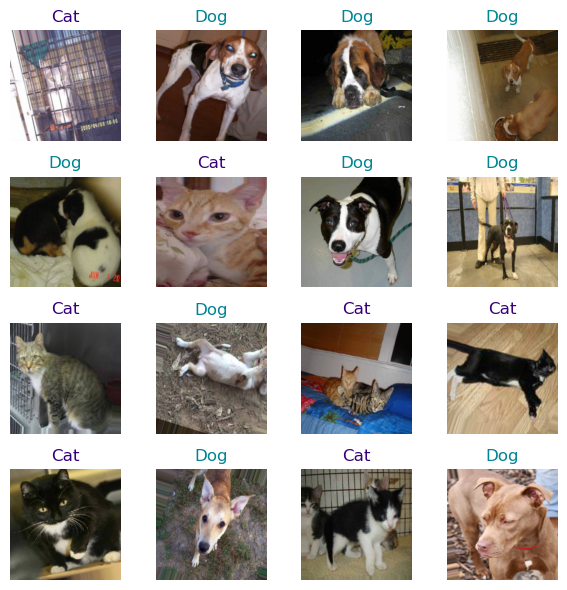

In [9]:
train_generator_cnn, val_generator_cnn, test_generator_cnn, single_test_images_cnn = load_data_cnn()
plot_images(train_generator_cnn)

In [10]:
model_cnn, history_cnn = cnn_model(train_generator_cnn, val_generator_cnn)

Epoch 1/50
200/200 [==============================] - 61s 290ms/step - loss: 1.2256 - accuracy: 0.5197 - val_loss: 0.9342 - val_accuracy: 0.5365
Epoch 2/50
200/200 [==============================] - 58s 288ms/step - loss: 0.8362 - accuracy: 0.5631 - val_loss: 1.4398 - val_accuracy: 0.5041
Epoch 3/50
200/200 [==============================] - 58s 288ms/step - loss: 0.8058 - accuracy: 0.5793 - val_loss: 0.8252 - val_accuracy: 0.5965
Epoch 4/50
200/200 [==============================] - 58s 287ms/step - loss: 0.7860 - accuracy: 0.5982 - val_loss: 0.7105 - val_accuracy: 0.6121
Epoch 5/50
200/200 [==============================] - 58s 288ms/step - loss: 0.7355 - accuracy: 0.6435 - val_loss: 0.7519 - val_accuracy: 0.6040
Epoch 6/50
200/200 [==============================] - 58s 288ms/step - loss: 0.7195 - accuracy: 0.6518 - val_loss: 0.9952 - val_accuracy: 0.6059

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
Epoch 7/50
200/200 [=============================

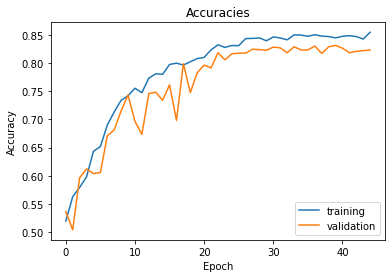

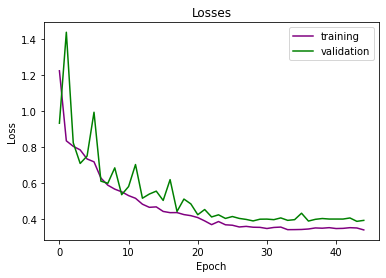

In [11]:
plots(history_cnn)

In [12]:
evaluate_model(model_cnn, test_generator_cnn)


Model Evaluation on Test-Data:
2017/2017 [==============================] - 9s 5ms/step - loss: 0.4057 - accuracy: 0.8369


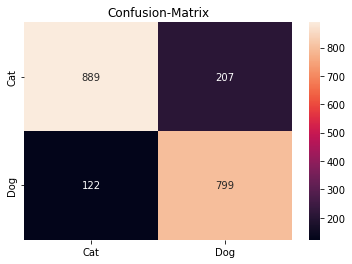

In [13]:
plot_cm(model_cnn, test_generator_cnn)

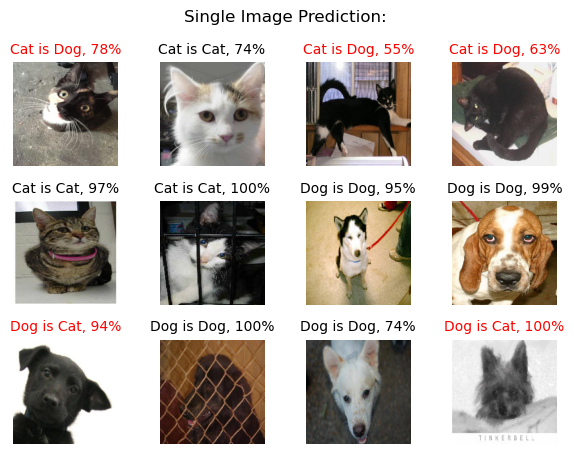

In [14]:
plot_single_image_test(model_cnn, single_test_images_cnn)

# EfficientNet

Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
Found 2017 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


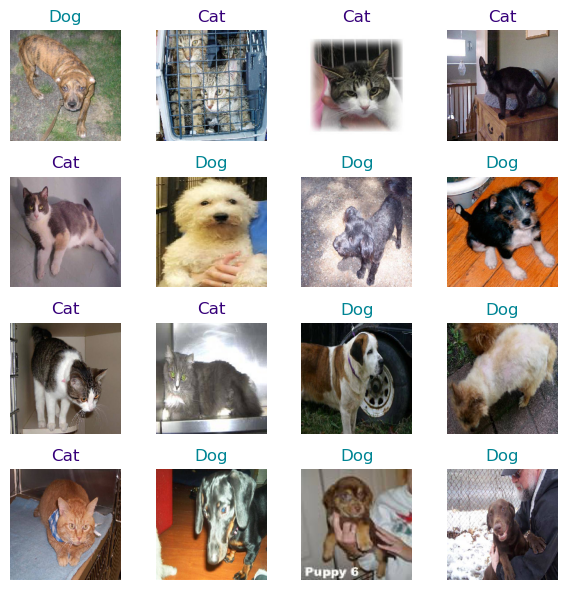

In [15]:
train_generator_effnet, val_generator_effnet, test_generator_effnet, single_test_images_effnet = load_data_effnet()
plot_images(train_generator_effnet)

In [16]:
model_effnet, history_effnet = effnet_model(train_generator_effnet, val_generator_effnet)

Epoch 1/50
200/200 [==============================] - 68s 313ms/step - loss: 0.4942 - accuracy: 0.7787 - val_loss: 0.6946 - val_accuracy: 0.5009
Epoch 2/50
200/200 [==============================] - 61s 307ms/step - loss: 0.2597 - accuracy: 0.9211 - val_loss: 0.6597 - val_accuracy: 0.5978
Epoch 3/50
200/200 [==============================] - 61s 306ms/step - loss: 0.1731 - accuracy: 0.9438 - val_loss: 0.3504 - val_accuracy: 0.8520
Epoch 4/50
200/200 [==============================] - 62s 307ms/step - loss: 0.1283 - accuracy: 0.9558 - val_loss: 0.1312 - val_accuracy: 0.9519
Epoch 5/50
200/200 [==============================] - 62s 308ms/step - loss: 0.1029 - accuracy: 0.9672 - val_loss: 0.0925 - val_accuracy: 0.9600
Epoch 6/50
200/200 [==============================] - 62s 308ms/step - loss: 0.0852 - accuracy: 0.9705 - val_loss: 0.1249 - val_accuracy: 0.9438
Epoch 7/50
200/200 [==============================] - 62s 307ms/step - loss: 0.0695 - accuracy: 0.9772 - val_loss: 0.0644 - val_ac

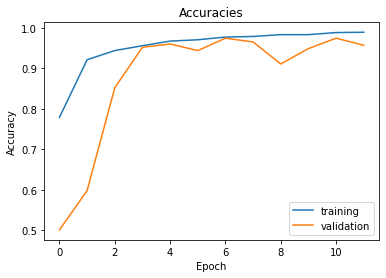

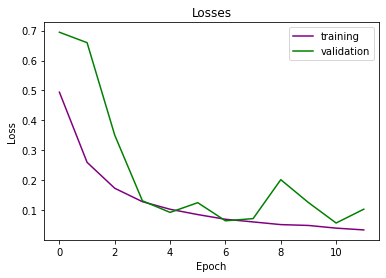

In [17]:
plots(history_effnet)

In [18]:
evaluate_model(model_effnet, test_generator_effnet)


Model Evaluation on Test-Data:
2017/2017 [==============================] - 30s 15ms/step - loss: 0.0682 - accuracy: 0.9757


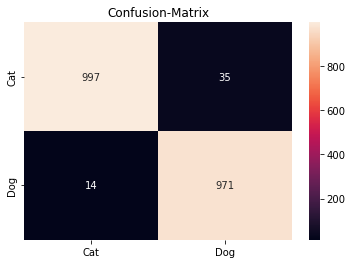

In [19]:
plot_cm(model_effnet, test_generator_effnet)

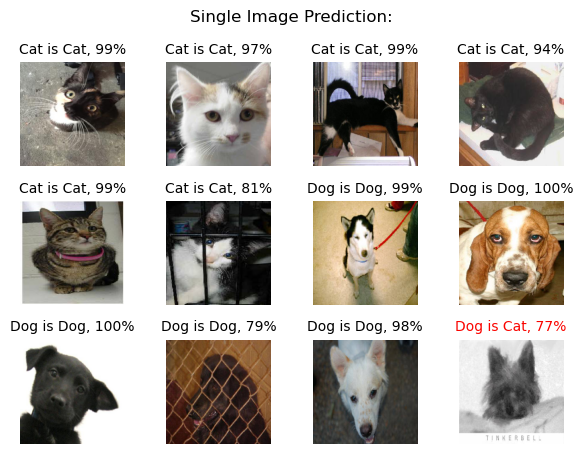

In [20]:
plot_single_image_test(model_effnet, single_test_images_effnet)